# Zipline Architecture
This notebook examines the structure of zipline.

## Objects


### [Backtest Example](https://analyzingalpha.com/a-simple-trading-strategy-in-zipline-and-jupyter)

In [1]:
%load_ext zipline

In [2]:
import zipline
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
from datetime import datetime
import pytz

In [3]:
def initialize(context):
        context.i = 0
        context.asset = symbol('AAPL')
        set_benchmark(symbol('AAPL'))

In [4]:
def handle_data(context, data):
        # Skip first 200 days to get full windows
        context.i += 1
        if context.i < 200:
                        return
        # Compute averages
        # data.history() has to be called with the same params
        # from above and returns a pandas dataframe.
        short_mavg = data.history(context.asset, 'price', bar_count=50, frequency="1d").mean()
        long_mavg = data.history(context.asset, 'price', bar_count=200, frequency="1d").mean()

        # Trading logic
        open_orders = get_open_orders()

        if context.asset not in open_orders:
                if short_mavg > long_mavg:
                        # order_target orders as many shares as needed to
                        # achieve the desired number of shares.
                        order_target_percent(context.asset, 1.0)
                elif short_mavg < long_mavg:
                        order_target_percent(context.asset, 0.0)

        # Save values for later inspection
        record(AAPL=data.current(context.asset, 'price'),
                        short_mavg=short_mavg,
                        long_mavg=long_mavg)

In [13]:
# Only used when function is called from commandline.
# def analyze(context, perf):
#     perf.to_csv('perf.csv')
    
#     fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

#     # portfolio value
#     perf.portfolio_value.plot(ax=ax[0])
#     ax[0].set_ylabel('portfolio value in €')

#     # asset
#     perf.price.plot(ax=ax[1])
#     ax[1].set_ylabel('price in €')

#     # mark transactions
#     perf_trans = perf.loc[[t != [] for t in perf.transactions]]
#     buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
#     sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
#     ax[1].plot(buys.index, perf.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
#     ax[1].plot(sells.index, perf.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')

#     # daily returns
#     perf.returns.plot(ax=ax[2])
#     ax[2].set_ylabel('daily returns')

#     fig.suptitle('Buy and Hold Strategy - AAPL', fontsize=16)
#     plt.legend()
#     plt.savefig(('buy_and_hold'), dpi=300)
#     plt.show()

#     print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))


### Running 

```python
%%zipline --start 2000-1-1 --end 2017-12-31
```



In [17]:
# import trading_calendars as tc
# tc.get_calendar("XNYS")
# from .trading_calendar import TradingCalendar
zipline.utils.calendar_utils.get_calendar_names()
zipline.utils.calendar_utils.get_calendar("NYSE")

In [21]:
import pandas as pd


Timestamp('2015-01-01 00:00:00')

In [22]:

# start = datetime(2015, 1, 1, 0, 0, 0, 0, pytz.utc)
# end = datetime(2017, 12, 31, 0, 0, 0, 0, pytz.utc)

# start = datetime(2015, 1, 1, 0, 0, 0, 0)
# end = datetime(2017, 12, 31, 0, 0, 0, 0)
start = pd.Timestamp("2015-01-01")
end = pd.Timestamp("2017-12-31")

import pandas_datareader.data as web
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
calendar= zipline.utils.calendar_utils.get_calendar("NYSE")
benchmark_returns = sp500.pct_change().tz_localize('UTC')

perf = zipline.run_algorithm(start=start,
                                end=end,
                                initialize=initialize, # Function to initialize
                                capital_base=10000,
                                handle_data=handle_data,# Function to handle data
                             bundle="quandl",# 2023-05-27 20:39:23.667305"
                             data_frequency='daily',
                             trading_calendar=calendar
                             # benchmark_returns=benchmark_returns,
                             ) 

In [31]:
perf.positions

2015-01-02 21:00:00+00:00                                                   []
2015-01-05 21:00:00+00:00                                                   []
2015-01-06 21:00:00+00:00                                                   []
2015-01-07 21:00:00+00:00                                                   []
2015-01-08 21:00:00+00:00                                                   []
                                                   ...                        
2017-12-22 21:00:00+00:00    [{'sid': Equity(8 [AAPL]), 'amount': 94, 'cost...
2017-12-26 21:00:00+00:00    [{'sid': Equity(8 [AAPL]), 'amount': 94, 'cost...
2017-12-27 21:00:00+00:00    [{'sid': Equity(8 [AAPL]), 'amount': 94, 'cost...
2017-12-28 21:00:00+00:00    [{'sid': Equity(8 [AAPL]), 'amount': 94, 'cost...
2017-12-29 21:00:00+00:00    [{'sid': Equity(8 [AAPL]), 'amount': 94, 'cost...
Name: positions, Length: 755, dtype: object

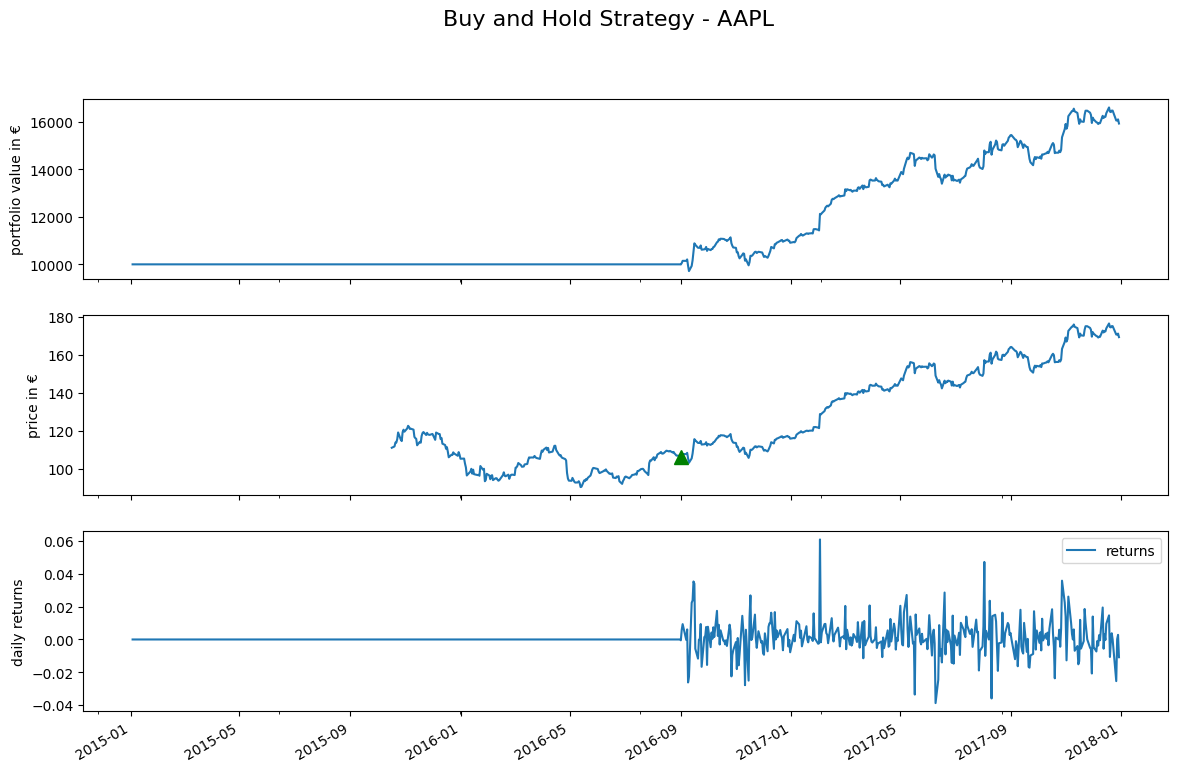

Final portfolio value (including cash): 15929.14$


In [32]:
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
# plot results

buy_and_hold_results =deepcopy(perf)
buy_and_hold_results['price'] = buy_and_hold_results['AAPL']
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[14, 9])

# portfolio value
buy_and_hold_results.portfolio_value.plot(ax=ax[0])
ax[0].set_ylabel('portfolio value in €')

# asset
buy_and_hold_results.price.plot(ax=ax[1])
ax[1].set_ylabel('price in €')

# mark transactions
perf_trans = buy_and_hold_results.loc[[t != [] for t in buy_and_hold_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax[1].plot(buys.index, buy_and_hold_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax[1].plot(sells.index, buy_and_hold_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')

# daily returns
buy_and_hold_results.returns.plot(ax=ax[2])
ax[2].set_ylabel('daily returns')

fig.suptitle('Buy and Hold Strategy - AAPL', fontsize=16)
plt.legend()
plt.savefig('Buy_and_Hold_Strategy_AAPL', dpi=300)
plt.show()

print('Final portfolio value (including cash): {}$'.format(np.round(buy_and_hold_results.portfolio_value[-1], 2)))


### [Portfolio](https://github.com/quantopian/zipline/blob/014f1fc339dc8b7671d29be2d85ce57d3daec343/zipline/protocol.py#L163)


```python
    """Object providing read-only access to current portfolio state.

    Parameters
    ----------
    start_date : pd.Timestamp
        The start date for the period being recorded.
    capital_base : float
        The starting value for the portfolio. This will be used as the starting
        cash, current cash, and portfolio value.

    Attributes
    ----------
    positions : zipline.protocol.Positions
        Dict-like object containing information about currently-held positions.
    cash : float
        Amount of cash currently held in portfolio.
    portfolio_value : float
        Current liquidation value of the portfolio's holdings.
        This is equal to ``cash + sum(shares * price)``
    starting_cash : float
        Amount of cash in the portfolio at the start of the backtest.
    """
```

Attributes
#### Portfolio Metrics

##### PnL (Profit And Losses)

##### Sharpe

#### Orders



##### [order_target_percent](https://github.com/quantopian/zipline/blob/014f1fc339dc8b7671d29be2d85ce57d3daec343/zipline/api.pyi#LL370C11-L370C11)

```python
  """Place an order to adjust a position to a target percent of the
    current portfolio value. If the position doesn't already exist, this is
    equivalent to placing a new order. If the position does exist, this is
    equivalent to placing an order for the difference between the target
    percent and the current percent.

    Parameters
    ----------
    asset : Asset
        The asset that this order is for.
    target : float
        The desired percentage of the portfolio value to allocate to
        ``asset``. This is specified as a decimal, for example:
        0.50 means 50%.
    limit_price : float, optional
        The limit price for the order.
    stop_price : float, optional
        The stop price for the order.
    style : ExecutionStyle
        The execution style for the order.

    Returns
    -------
    order_id : str
        The unique identifier for this order.

    Notes
    -----
    ``order_target_value`` does not take into account any open orders. For
    example:

    .. code-block:: python

       order_target_percent(sid(0), 10)
       order_target_percent(sid(0), 10)

    This code will result in 20% of the portfolio being allocated to sid(0)
    because the first call to ``order_target_percent`` will not have been
    filled when the second ``order_target_percent`` call is made.

    See :func:`zipline.api.order` for more information about
    ``limit_price``, ``stop_price``, and ``style``

    See Also
    --------
    :class:`zipline.finance.execution.ExecutionStyle`
    :func:`zipline.api.order`
    :func:`zipline.api.order_target`
    :func:`zipline.api.order_target_value`
    """
```

### [Account](https://github.com/quantopian/zipline/blob/014f1fc339dc8b7671d29be2d85ce57d3daec343/zipline/protocol.py#L248)

```python
    """
    The account object tracks information about the trading account. The
    values are updated as the algorithm runs and its keys remain unchanged.
    If connected to a broker, one can update these values with the trading
    account values as reported by the broker.
    """
```


### [Ledger](https://github.com/quantopian/zipline/blob/014f1fc339dc8b7671d29be2d85ce57d3daec343/zipline/finance/ledger.py#L342)
    ```python
        """The ledger tracks all orders and transactions as well as the current
        state of the portfolio and positions.

        Attributes
        ----------
        portfolio : zipline.protocol.Portfolio
            The updated portfolio being managed.
        account : zipline.protocol.Account
            The updated account being managed.
        position_tracker : PositionTracker
            The current set of positions.
        todays_returns : float
            The current day's returns. In minute emission mode, this is the partial
            day's returns. In daily emission mode, this is
            ``daily_returns[session]``.
        daily_returns_series : pd.Series
            The daily returns series. Days that have not yet finished will hold
            a value of ``np.nan``.
        daily_returns_array : np.ndarray
            The daily returns as an ndarray. Days that have not yet finished will
            hold a value of ``np.nan``.
        """
```